In [2]:
import pandas as pd
import numpy as np

In [3]:
url =  "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv"

data = pd.read_csv(url)

data.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [4]:
data.dtypes

Laptop           object
Status           object
Brand            object
Model            object
CPU              object
RAM               int64
Storage           int64
Storage type     object
GPU              object
Screen          float64
Touch            object
Final Price     float64
dtype: object

In [5]:
df = data.copy()
df.columns = df.columns.str.lower().str.replace(' ', '_')

s = df.dtypes[df.dtypes == "object"]
print(s.index, "\n")
print(s.values)

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'storage_type', 'gpu',
       'touch'],
      dtype='object') 

[dtype('O') dtype('O') dtype('O') dtype('O') dtype('O') dtype('O')
 dtype('O') dtype('O')]


In [6]:
strings = list(df.dtypes[df.dtypes == "object"].index)
numeric = list(df.dtypes[df.dtypes != "object"].index)

In [7]:
df = df[numeric]
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


In [8]:
for col in df.columns:
    print(col)
    if len(df[col].unique()) > 10:
        print(df[col].unique()[:5])
        print("no. of unique values:",df[col].nunique(),"\n")
    else:
        print(df[col].unique())
        print("no. of unique values:",df[col].nunique(),"\n")

ram
[  8  16  32  12   4  64 128   6  40]
no. of unique values: 9 

storage
[ 512  256 1000   64  128]
no. of unique values: 12 

screen
[15.6 17.3 14.  16.1 13.3]
no. of unique values: 29 

final_price
[1009.    299.    789.   1199.    669.01]
no. of unique values: 1440 



In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

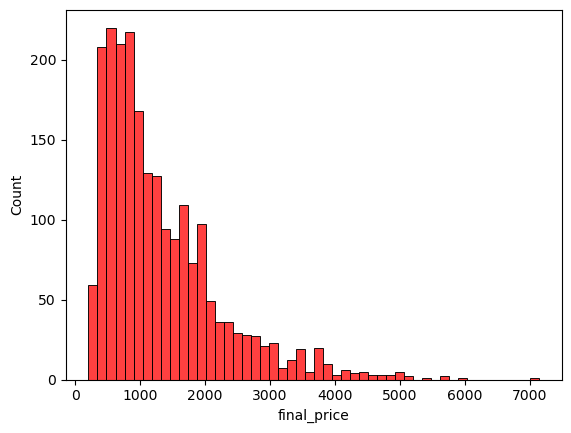

In [10]:
# Data is right-skewed (long tailed) so we will need to evaluate the log-transformation
sns.histplot(df.final_price, bins=50, color="red")

plt.show()

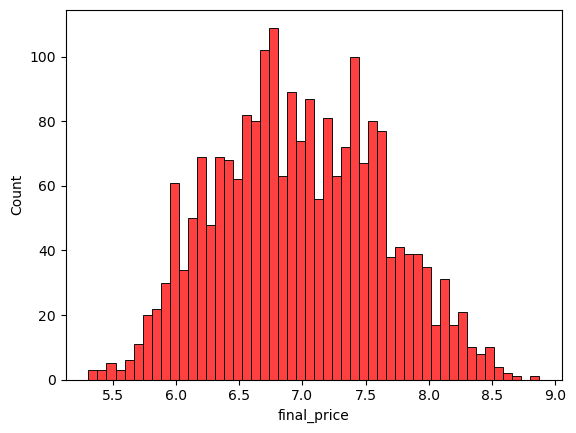

In [11]:
price_logs = np.log1p(df.final_price)

sns.histplot(price_logs, bins=50, color="red")

plt.show()

### Question 1

In [12]:
df.isnull().sum()[df.isnull().sum() != 0]

screen    4
dtype: int64

column with missing values: 'screen'

### Question 2

In [13]:
df.ram.median()

16.0

In [14]:
len(df)

2160

### Preparing the dataframe

In [20]:
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - n_val -n_test

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [21]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]


def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

### Question 3

### RMSE (filling the missing values of 'screen' with 0s vs. with the mean value) "without regularization"

### 01. filling missing values with 0

In [22]:
df_train.isnull().sum()

ram        0
storage    0
screen     3
dtype: int64

In [23]:
rows_with_missing_values = df_train[df_train.isnull().any(axis=1)]
print(rows_with_missing_values)
indexes_of_rows_with_missing_values = rows_with_missing_values.index.tolist()

      ram  storage  screen
124    16      512     NaN
1062   16      512     NaN
1238    8      256     NaN


In [26]:
def prepare_X(df):
    df_num = df.copy()
    return df_num.fillna(0).values

X_train = prepare_X(df_train)

In [27]:
print("Rows with missing values after filling them:")
print(X_train[indexes_of_rows_with_missing_values])

w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse_with_zero = round(rmse(y_val, y_pred), 2).item()
print(f"\nRMSE: {rmse_with_zero}")

Rows with missing values after filling them:
[[ 16. 512.   0.]
 [ 16. 512.   0.]
 [  8. 256.   0.]]

RMSE: 597.36


### 02. filling missing values with the mean

In [28]:
# need to change attributes: X_train_mean, X_val_mean
df_train_screen_mean = df_train['screen'].mean()

def prepare_X_mean(df):
    df_num = df.copy()
    return df_num.fillna(df_train_screen_mean).values

X_train_mean = prepare_X_mean(df_train)
print("Rows with missing values after filling them:")
print(X_train_mean[indexes_of_rows_with_missing_values])

Rows with missing values after filling them:
[[ 16.         512.          15.16353442]
 [ 16.         512.          15.16353442]
 [  8.         256.          15.16353442]]


In [29]:
w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)
X_val_mean = prepare_X_mean(df_val)

y_pred_mean = w0_mean + X_val_mean.dot(w_mean)

rmse_with_mean = round(rmse(y_val, y_pred_mean), 2).item()
print(f"\nRMSE: {rmse_with_mean}")


RMSE: 600.27


In [31]:
if rmse_with_zero < rmse_with_mean:
    print("With 0 gives better results.")
elif rmse_with_zero > rmse_with_mean:
    print("With mean gives better results.")   
else:
    print("Both are equally good.")    

With 0 gives better results.


### Question 4

In [39]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [40]:
X_train_reg = prepare_X(df_train)
print("Rows with missing values after filling them:")
print(X_train_reg[indexes_of_rows_with_missing_values])

Rows with missing values after filling them:
[[ 16. 512.   0.]
 [ 16. 512.   0.]
 [  8. 256.   0.]]


In [43]:
r_used = 0.001

w0_reg, w_reg = train_linear_regression_reg(X_train_reg, y_train, r_used)
X_val_reg = prepare_X(df_val)

y_pred_reg = w0_reg + X_val_reg.dot(w_reg)

rmse_with_reg = round(rmse(y_val, y_pred_reg), 2).item()
print(f"\nRMSE: {rmse_with_mean} For value of r = {r_used}")


RMSE: 600.27 For value of r = 0.001


In [76]:
X_train_reg = prepare_X(df_train)
X_val_reg = prepare_X(df_val)

r_list = [0, 0.01, 0.1, 1,  10, 100]
scores = []

for r in r_list:

    w0_reg, w_reg = train_linear_regression_reg(X_train_reg, y_train, r)
    
    y_pred_reg = w0_reg + X_val_reg.dot(w_reg)
    
    rmse_with_reg = round(rmse(y_val, y_pred_reg), 2).item()

    scores.append(rmse_with_reg)
    print(f"\nRMSE: {rmse_with_reg} For value of r = {r}")

print(f"\nThe smallest RMSE value = {min(scores)}")


RMSE: 597.36 For value of r = 0

RMSE: 597.36 For value of r = 0.01

RMSE: 597.35 For value of r = 0.1

RMSE: 597.21 For value of r = 1

RMSE: 597.06 For value of r = 10

RMSE: 597.9 For value of r = 100

The smallest RMSE value = 597.06


In [77]:
r_num = np.array(r_list)
scores_num = np.array(scores)

scores_df = pd.DataFrame({"r": r_num, "score" : scores_num})
scores_df.loc[scores_df["score"].idxmin()]  

r         10.00
score    597.06
Name: 4, dtype: float64

### Question 5

In [78]:
def prepare_data(df, s):

    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - n_val - n_test
    
    idx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)
    
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']


    return df_train, df_val, df_test, y_train, y_val, y_test

In [79]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores_seed = []

for seed in seeds:
    df_train_seed, df_val_seed, df_test_seed, y_train_seed, y_val_seed, y_test_seed = prepare_data(df, s=seed)
    
    X_train_seed = prepare_X(df_train_seed)
    X_val_seed = prepare_X(df_val_seed)
    
    w0_seed, w_seed = train_linear_regression(X_train_seed, y_train_seed)
    X_val_seed = prepare_X(df_val_seed)
    
    y_pred_seed = w0_seed + X_val_seed.dot(w_seed)
    
    rmse_with_diff_seed = round(rmse(y_val_seed, y_pred_seed), 2).item()

    scores_seed.append(rmse_with_diff_seed)
    print(f"\nRMSE: {rmse_with_diff_seed}")


RMSE: 565.45

RMSE: 636.8

RMSE: 588.96

RMSE: 597.81

RMSE: 571.96

RMSE: 573.24

RMSE: 647.34

RMSE: 550.44

RMSE: 587.33

RMSE: 576.1


In [83]:
scores_seed_num = np.array(scores_seed)

round(scores_seed_num.std(), 3)

29.176

### Question 6

In [84]:
df_train_6, df_val_6, df_test_6, y_train_6, y_val_6, y_test_6 = prepare_data(df, s=9)

In [87]:
y_train_6

array([1592.89, 1349.  ,  549.  , ...,  429.01, 1599.  , 4999.01])

In [91]:
df_train_val_full = pd.concat([df_train_6, df_val_6], axis=0)
y_train_val_full = np.concatenate((y_train_6, y_val_6))

X_train_val_full = prepare_X(df_train_val_full)
X_test = prepare_X(df_test_6)

w0_6, w_6 = train_linear_regression_reg(X_train_val_full, y_train_val_full, r=0.001)

y_pred_6 = w0_6 + X_test.dot(w_6)

rmse_with_diff_seed = round(rmse(y_test_6, y_pred_6), 2).item()

rmse_with_diff_seed

608.61

### Question 6

In [75]:
w0_zeros, w_zeros = train_linear_regression(X_train_zeros, y_train)
y_pred_zeros = w0_zeros + X_train_zeros.dot(w_zeros)
 
w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)
y_pred_mean = w0_mean + X_train_mean.dot(w_mean)

In [76]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [79]:
round(rmse(y_train, y_pred_zeros), 2)

0.45

In [80]:
round(rmse(y_train, y_pred_mean),2)

0.45

### 

### 

### BBBBB

### 

### result: Both are equally good

In [81]:
w0_zeros

6.727163706116559

In [82]:
w_zeros

array([ 0.02630589,  0.00066041, -0.03651909])

In [83]:
w0_mean

6.855566544140346

In [84]:
w_mean

array([ 0.02650252,  0.00066643, -0.04534341])

In [85]:
# With regularization
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [86]:
df_train.isnull().sum()

ram        0
storage    0
screen     3
dtype: int64

In [90]:
df_train.isnull().sum()

ram        0
storage    0
screen     0
dtype: int64

In [93]:
df_val.isnull().sum()

ram        0
storage    0
screen     1
dtype: int64

In [94]:
df_val['screen'] = df_val['screen'].fillna(0)

C:\Users\MUHAMMED IBRAHIM\AppData\Local\Temp\ipykernel_9832\1426529302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['screen'] = df_val['screen'].fillna(0)


In [95]:
df_val.isnull().sum()

ram        0
storage    0
screen     0
dtype: int64

In [96]:
X_train = df_train.values
X_val = df_val.values

In [102]:
w0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

y_pred = w0 + X_val.dot(w)
round(rmse(y_val, y_pred), 2)

0.43

In [103]:
for r in [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(r, w0, score)

0.0 6.727163706116559 0.4288635315474399
1e-05 6.727157541080534 0.4288635193013878
0.0001 6.7271020562686665 0.42886340911857396
0.001 6.726547258699545 0.4288623104219867
0.01 6.721004333264144 0.428851636053407
0.1 6.666075503831725 0.4287756009707556
1 6.162616499463823 0.43059329897431
10 3.516754720793905 0.5075657769236755


### Smallest RMSE = 0.4287756009707556  for (r = 0.1) 